<a href="https://colab.research.google.com/github/Zardian18/Conditional-WGAN-GP-Fashion-MNIST/blob/master/CGAN_fashion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://raw.githubusercontent.com/Zardian18/helper-functions-colab/master/helper.py

--2024-01-10 21:20:19--  https://raw.githubusercontent.com/Zardian18/helper-functions-colab/master/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17171 (17K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]  16.77K  --.-KB/s    in 0s      

2024-01-10 21:20:19 (76.6 MB/s) - ‘helper.py’ saved [17171/17171]



In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks, utils, metrics, losses, optimizers
from helper import sample_batch, display, get_vector_from_label, add_vector_to_images, morph_faces
import pandas as pd
import numpy as np
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
from PIL import Image
from keras.datasets import fashion_mnist
from tensorflow.keras.utils import plot_model

In [3]:
(x_train, y_train), (x_test, y_test)= fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


In [4]:
x_train[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,
          0,   0,  13,  73,   0,   0,   1,   4,   0,   0,   0,   0,   1,
          1,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
          0,  36, 136, 127,  62,  54,   0,   0,   0,   1,   3,   4,   0,
          0,   3],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   6,
          0, 102, 204, 176, 134, 144, 123,  23,   0,   0,   0,   0,  12,
         10,   0],
       [  

In [5]:
y_train[:5]

array([9, 0, 0, 3, 0], dtype=uint8)

In [7]:
y_test[:5]

array([9, 2, 1, 1, 6], dtype=uint8)

In [8]:
y_train =tf.one_hot(y_train, depth=10)

In [9]:
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [10]:
y_train.shape, y_test.shape

(TensorShape([60000, 10]), (10000,))

In [11]:
x_train = (tf.cast(x_train, "float32")-127.5)/127.5

In [12]:
x_train= tf.expand_dims(x_train, axis=-1)

In [13]:
# x_train[0]

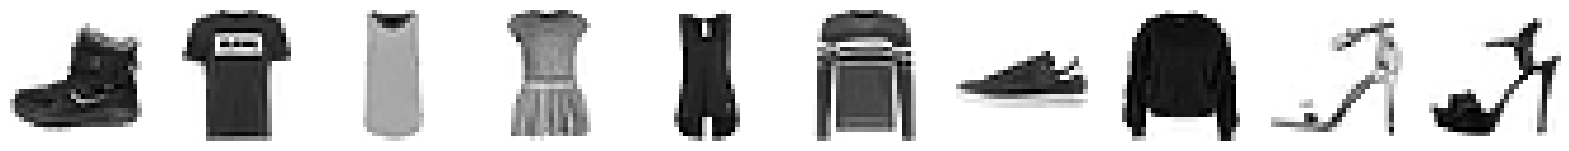

In [14]:
display(np.array(x_train))

## Critic

In [15]:
critic_input = layers.Input(shape=(28,28,1))

label_input = layers.Input(shape = (28,28,10))
# label_x = layers.Embedding(10, 50)(label_input)
# label_x = layers.Dense(28*28)(label_input)
# label_x = layers.Reshape((28,28,1))(label_x)

x = layers.Concatenate()([critic_input, label_input])

x = layers.Conv2D(128, 3, strides = 2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2D(128, 3, strides=2, padding ="same")(x)
x = layers.LayerNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Flatten()(x)
x = layers.Dropout(0.4)(x)

critic_output = layers.Dense(1)(x) # wgan-gp therefore no output normalization using sigmoid
critic= models.Model([critic_input, label_input], critic_output)
critic.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 28, 28, 10)]         0         []                            
                                                                                                  
 concatenate (Concatenate)   (None, 28, 28, 11)           0         ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 14, 14, 128)          12800     ['concatenate[0][0]']     

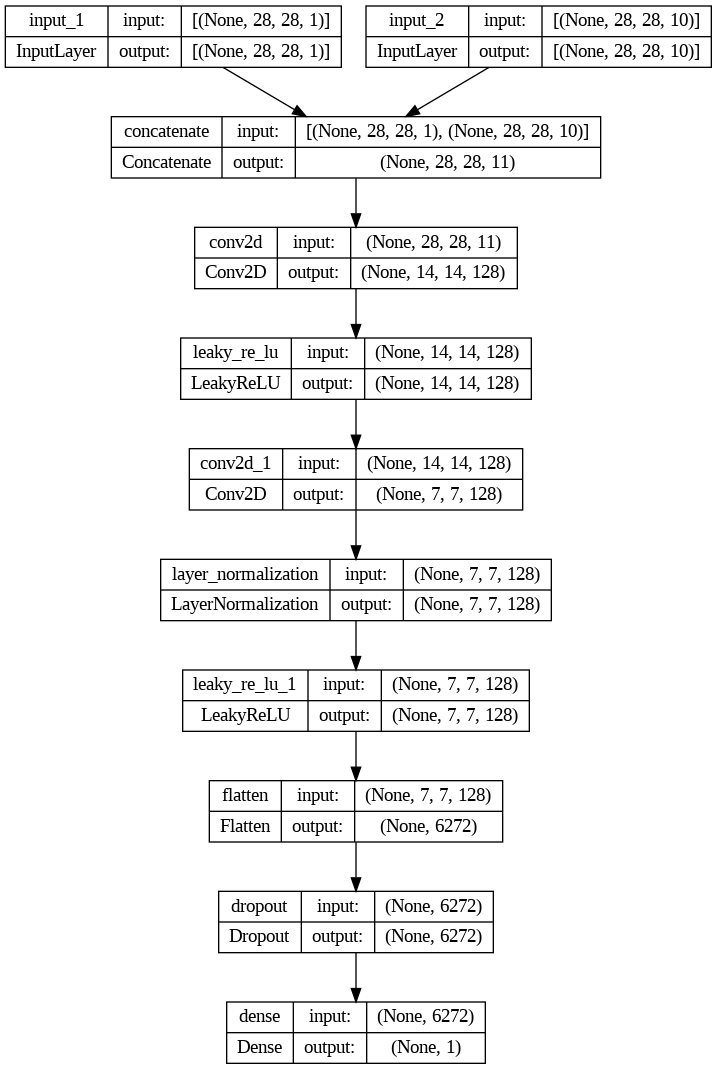

In [16]:
plot_model(critic, show_shapes=True, show_layer_names=True)

## Generator

In [17]:
generator_input = layers.Input(shape=(100,))

label_input = layers.Input(shape=(10,))
# label_x= layers.Embedding(10, 50)(label_input)
label_x = layers.Dense(7*7)(label_input)
label_x = layers.Reshape((7,7,1))(label_x)

x = layers.Dense(128*7*7)(generator_input)
x = layers.LeakyReLU(0.2)(x)
x = layers.Reshape((7,7,128))(x)

x = layers.Concatenate()([x, label_x])

x = layers.UpSampling2D(size=2)(x)
x = layers.Conv2DTranspose(128, 4, strides=1, padding="same", use_bias= False)(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.UpSampling2D(size=2)(x)
x = layers.Conv2DTranspose(128, 4, strides=1, padding="same", use_bias= False)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

generator_output = layers.Conv2D(1, 7, activation="tanh", padding="same", use_bias=False)(x)

generator = models.Model([generator_input, label_input], generator_output)
generator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 dense_2 (Dense)             (None, 6272)                 633472    ['input_3[0][0]']             
                                                                                                  
 input_4 (InputLayer)        [(None, 10)]                 0         []                            
                                                                                                  
 leaky_re_lu_2 (LeakyReLU)   (None, 6272)                 0         ['dense_2[0][0]']             
                                                                                            

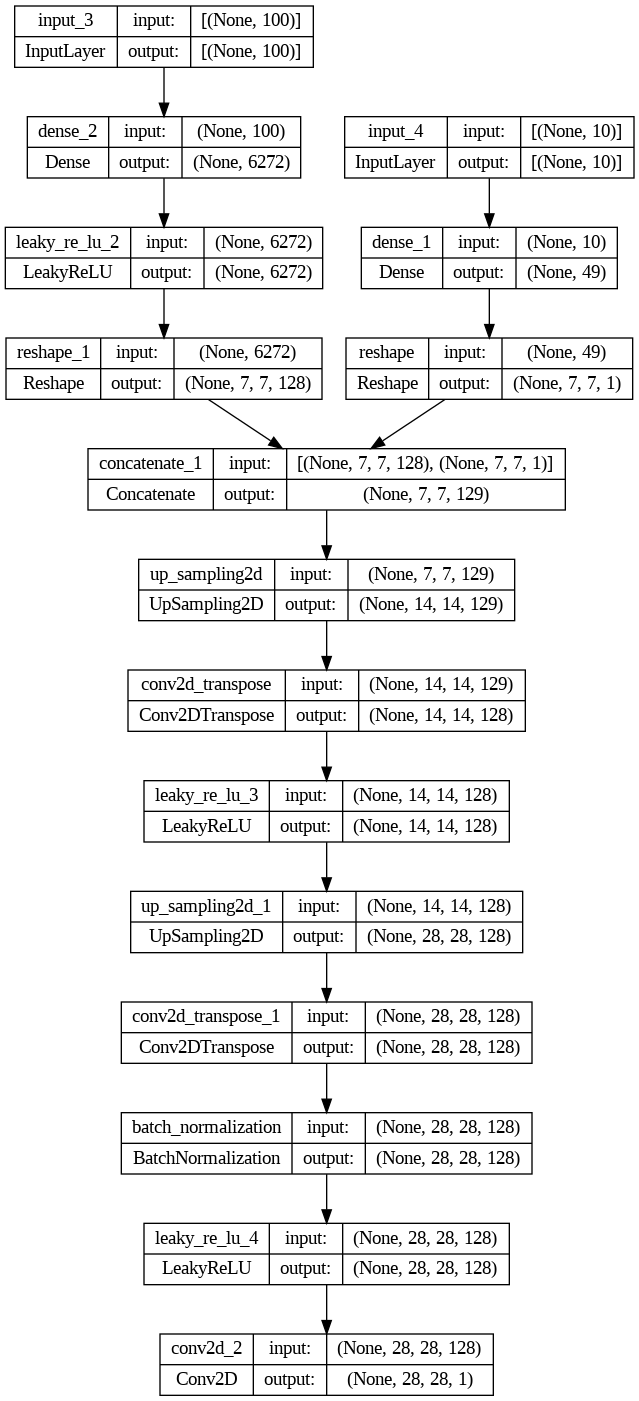

In [18]:
plot_model(generator, show_shapes=True, show_layer_names=True)

## Defining WGAN-GP

In [20]:
class ConditionalWGAN(models.Model):
    def __init__(self, critic, generator, latent_dim, critic_steps, gp_weight):
        super(ConditionalWGAN, self).__init__()
        self.critic = critic
        self.generator = generator
        self.latent_dim = latent_dim
        self.critic_steps = critic_steps
        self.gp_weight = gp_weight

    def compile(self, c_optimizer, g_optimizer):
        super(ConditionalWGAN, self).compile(run_eagerly=True)
        self.c_optimizer = c_optimizer
        self.g_optimizer = g_optimizer
        self.c_wass_loss_metric = metrics.Mean(name="c_wass_loss")
        self.c_gp_metric = metrics.Mean(name="c_gp")
        self.c_loss_metric = metrics.Mean(name="c_loss")
        self.g_loss_metric = metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [
            self.c_loss_metric,
            self.c_wass_loss_metric,
            self.c_gp_metric,
            self.g_loss_metric,
        ]

    def gradient_penalty(
        self, batch_size, real_images, fake_images, image_one_hot_labels
    ):
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.critic(
                [interpolated, image_one_hot_labels], training=True
            )

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, data):
        real_images, one_hot_labels = data

        image_one_hot_labels = one_hot_labels[:, None, None, :]
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=28, axis=1
        )
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=28, axis=2
        )

        batch_size = tf.shape(real_images)[0]

        for i in range(self.critic_steps):
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )

            with tf.GradientTape() as tape:
                fake_images = self.generator(
                    [random_latent_vectors, one_hot_labels], training=True
                )

                fake_predictions = self.critic(
                    [fake_images, image_one_hot_labels], training=True
                )
                real_predictions = self.critic(
                    [real_images, image_one_hot_labels], training=True
                )

                c_wass_loss = tf.reduce_mean(fake_predictions) - tf.reduce_mean(
                    real_predictions
                )
                c_gp = self.gradient_penalty(
                    batch_size, real_images, fake_images, image_one_hot_labels
                )
                c_loss = c_wass_loss + c_gp * self.gp_weight

            c_gradient = tape.gradient(c_loss, self.critic.trainable_variables)
            self.c_optimizer.apply_gradients(
                zip(c_gradient, self.critic.trainable_variables)
            )

        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )

        with tf.GradientTape() as tape:
            fake_images = self.generator(
                [random_latent_vectors, one_hot_labels], training=True
            )
            fake_predictions = self.critic(
                [fake_images, image_one_hot_labels], training=True
            )
            g_loss = -tf.reduce_mean(fake_predictions)

        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )

        self.c_loss_metric.update_state(c_loss)
        self.c_wass_loss_metric.update_state(c_wass_loss)
        self.c_gp_metric.update_state(c_gp)
        self.g_loss_metric.update_state(g_loss)

        return {m.name: m.result() for m in self.metrics}

In [21]:
cgan = ConditionalWGAN(
    critic=critic,
    generator=generator,
    latent_dim=100,
    critic_steps=3,
    gp_weight=10,
)

In [22]:
cgan.compile(
    c_optimizer=optimizers.Adam(
        learning_rate=0.0002, beta_1=0.5
    ),
    g_optimizer=optimizers.Adam(
        learning_rate=0.0002, beta_1=0.5
    ),
)

In [24]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        # 0 label
        zero_label = np.repeat([[1, 0,0,0,0,0,0,0,0,0]], self.num_img, axis=0)
        generated_images = self.model.generator(
            [random_latent_vectors, zero_label]
        )
        generated_images = generated_images * 127.5 + 127.5
        generated_images = generated_images.numpy()
        display(
            generated_images,
            save_to="./output/generated_img_%03d_label_0.png" % (epoch),
            cmap=None,
        )

        # 1 label
        one_label = np.repeat([[0, 1,0,0,0,0,0,0,0,0]], self.num_img, axis=0)
        generated_images = self.model.generator(
            [random_latent_vectors, one_label]
        )
        generated_images = generated_images * 127.5 + 127.5
        generated_images = generated_images.numpy()
        display(
            generated_images,
            save_to="./output/generated_img_%03d_label_1.png" % (epoch),
            cmap=None,
        )
        # 2 label
        two_label = np.repeat([[0, 0,1,0,0,0,0,0,0,0]], self.num_img, axis=0)
        generated_images = self.model.generator(
            [random_latent_vectors, two_label]
        )
        generated_images = generated_images * 127.5 + 127.5
        generated_images = generated_images.numpy()
        display(
            generated_images,
            save_to="./output/generated_img_%03d_label_2.png" % (epoch),
            cmap=None,
        )


In [25]:
! mkdir output/

Epoch 1/50
469/469 [==============================] - ETA: 0s - c_loss: -7.4403 - c_wass_loss: -8.8659 - c_gp: 0.1426 - g_loss: -4.7771
Saved to ./output/generated_img_000_label_0.png


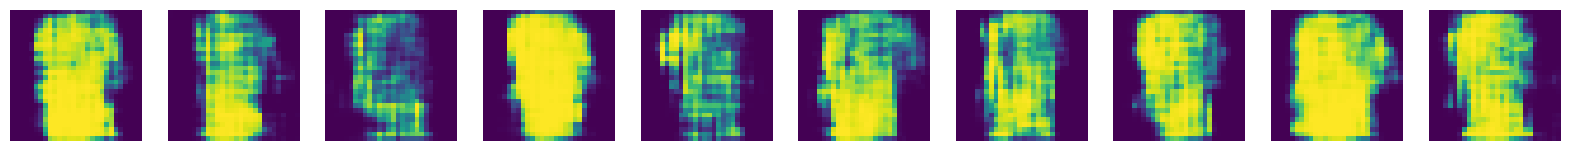


Saved to ./output/generated_img_000_label_1.png


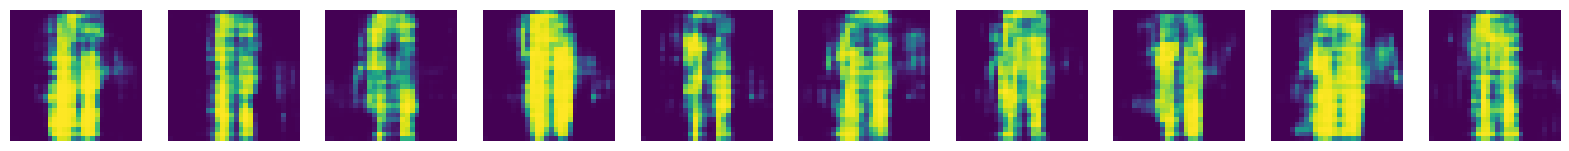


Saved to ./output/generated_img_000_label_2.png


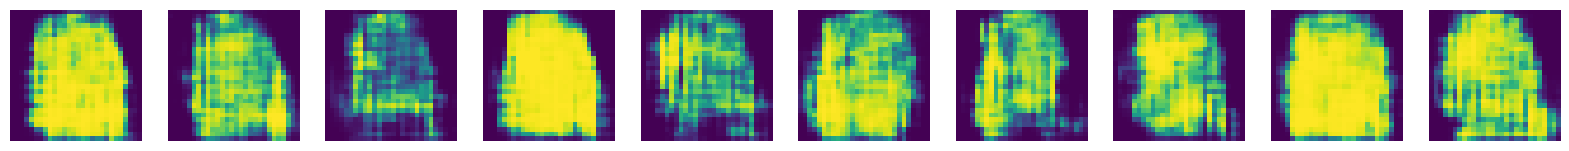

469/469 [==============================] - 207s 433ms/step - c_loss: -7.4403 - c_wass_loss: -8.8659 - c_gp: 0.1426 - g_loss: -4.7771
Epoch 2/50
469/469 [==============================] - ETA: 0s - c_loss: -3.5882 - c_wass_loss: -4.1156 - c_gp: 0.0527 - g_loss: -10.7534
Saved to ./output/generated_img_001_label_0.png


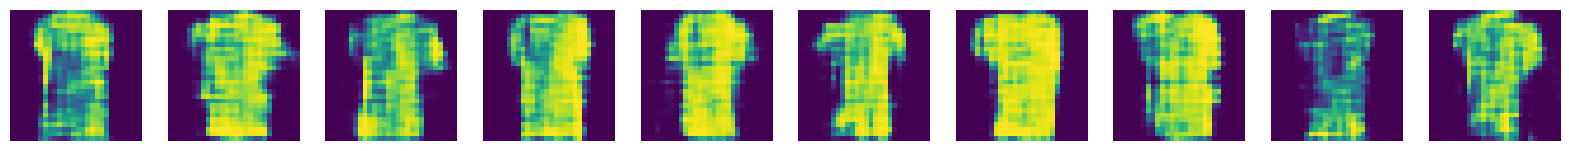


Saved to ./output/generated_img_001_label_1.png


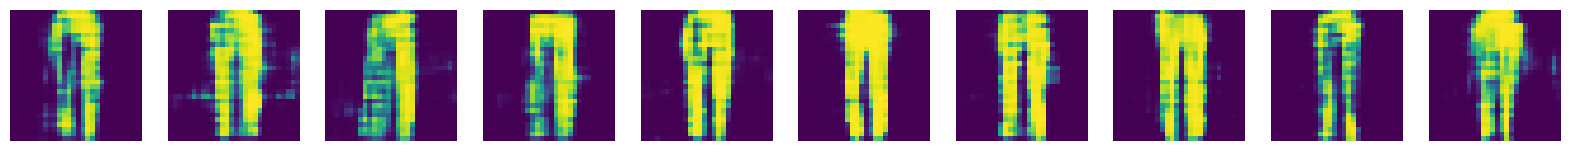


Saved to ./output/generated_img_001_label_2.png


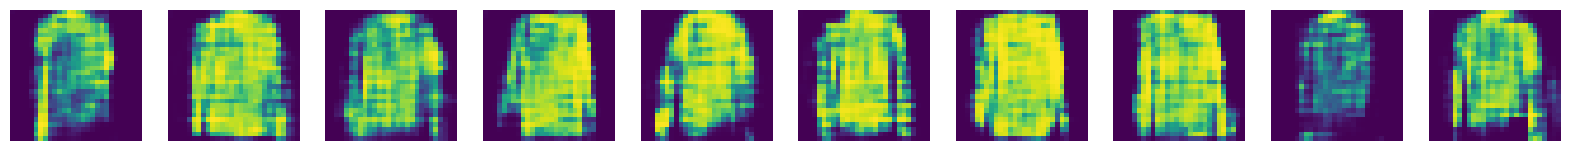

469/469 [==============================] - 217s 462ms/step - c_loss: -3.5882 - c_wass_loss: -4.1156 - c_gp: 0.0527 - g_loss: -10.7534
Epoch 3/50
469/469 [==============================] - ETA: 0s - c_loss: -2.7665 - c_wass_loss: -3.1439 - c_gp: 0.0377 - g_loss: -13.3310
Saved to ./output/generated_img_002_label_0.png


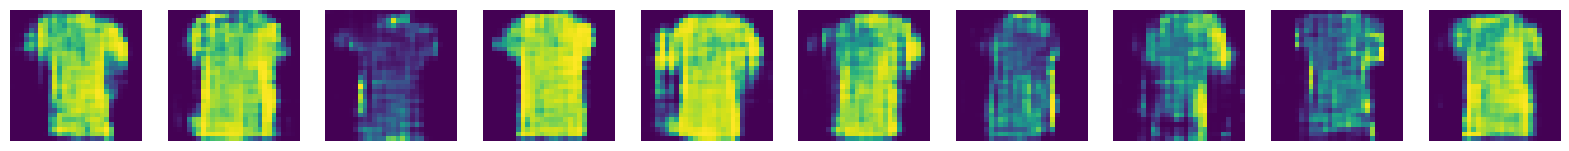


Saved to ./output/generated_img_002_label_1.png


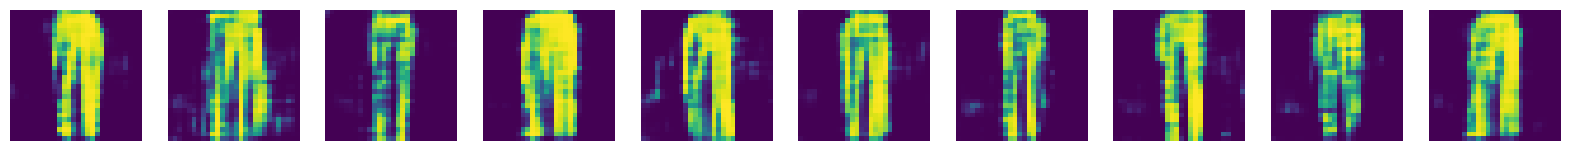


Saved to ./output/generated_img_002_label_2.png


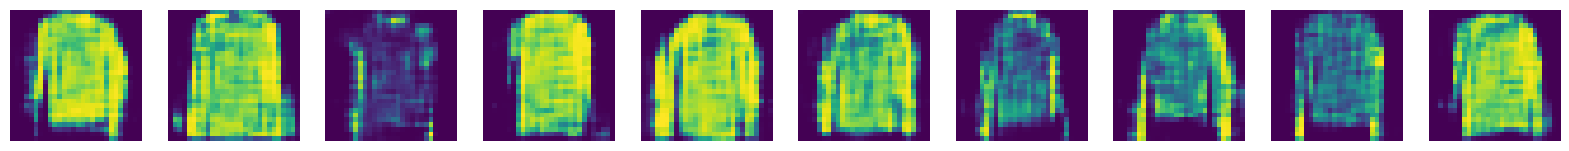

469/469 [==============================] - 199s 425ms/step - c_loss: -2.7665 - c_wass_loss: -3.1439 - c_gp: 0.0377 - g_loss: -13.3310
Epoch 4/50
469/469 [==============================] - ETA: 0s - c_loss: -2.2868 - c_wass_loss: -2.5731 - c_gp: 0.0286 - g_loss: -14.6767
Saved to ./output/generated_img_003_label_0.png


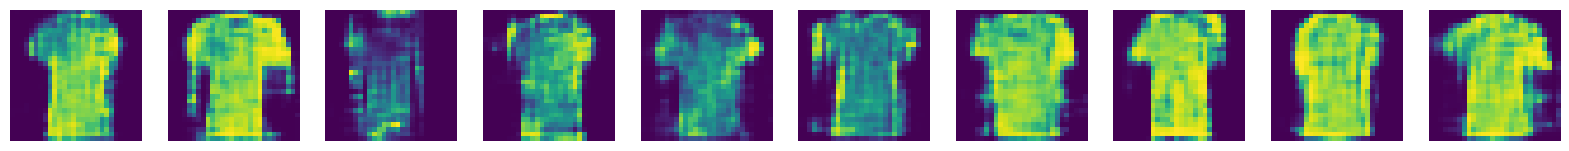


Saved to ./output/generated_img_003_label_1.png


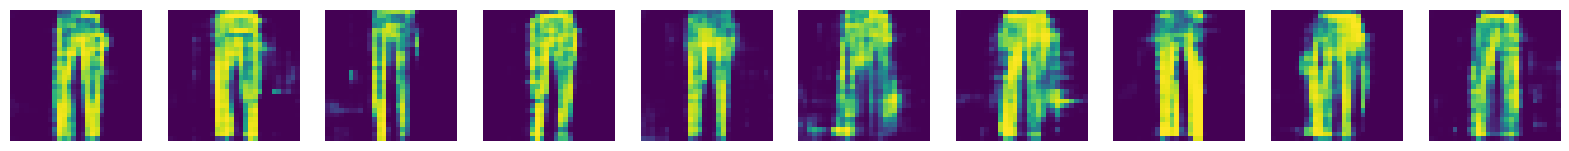


Saved to ./output/generated_img_003_label_2.png


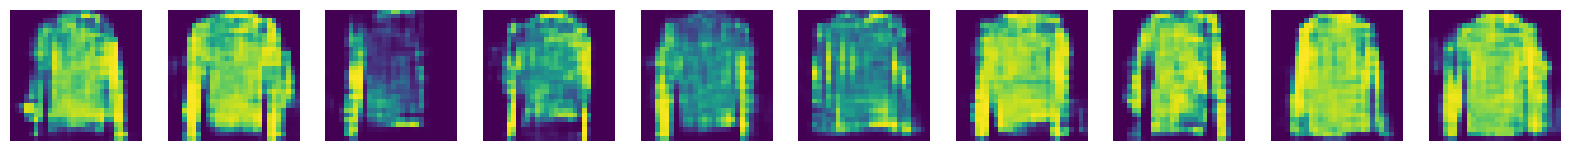

469/469 [==============================] - 199s 424ms/step - c_loss: -2.2868 - c_wass_loss: -2.5731 - c_gp: 0.0286 - g_loss: -14.6767
Epoch 5/50
469/469 [==============================] - ETA: 0s - c_loss: -2.0852 - c_wass_loss: -2.3424 - c_gp: 0.0257 - g_loss: -14.5886
Saved to ./output/generated_img_004_label_0.png


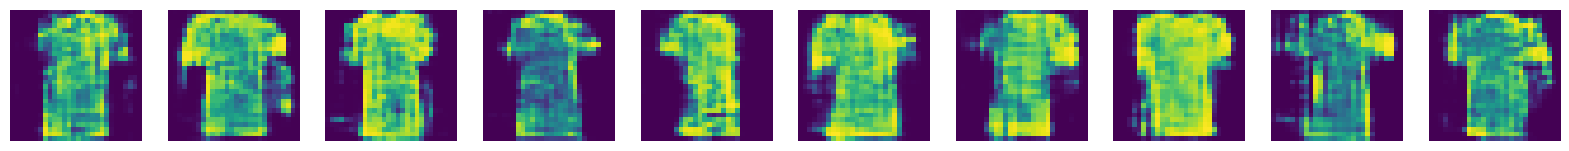


Saved to ./output/generated_img_004_label_1.png


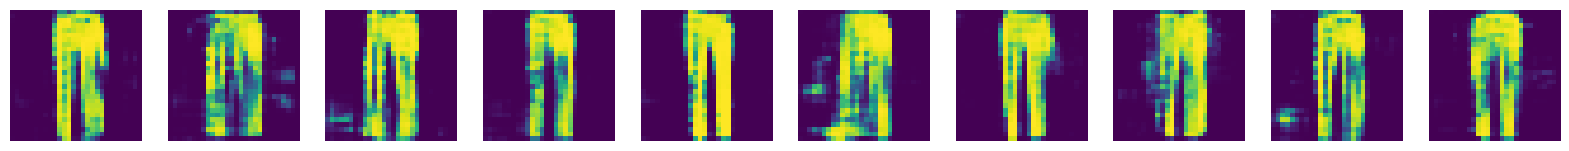


Saved to ./output/generated_img_004_label_2.png


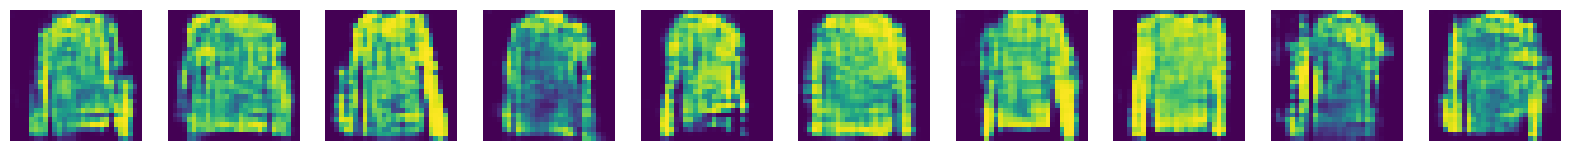

469/469 [==============================] - 199s 425ms/step - c_loss: -2.0852 - c_wass_loss: -2.3424 - c_gp: 0.0257 - g_loss: -14.5886
Epoch 6/50
469/469 [==============================] - ETA: 0s - c_loss: -1.8727 - c_wass_loss: -2.0893 - c_gp: 0.0217 - g_loss: -15.2013
Saved to ./output/generated_img_005_label_0.png


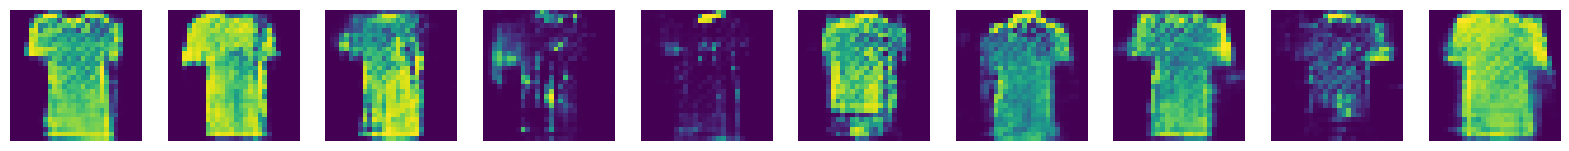


Saved to ./output/generated_img_005_label_1.png


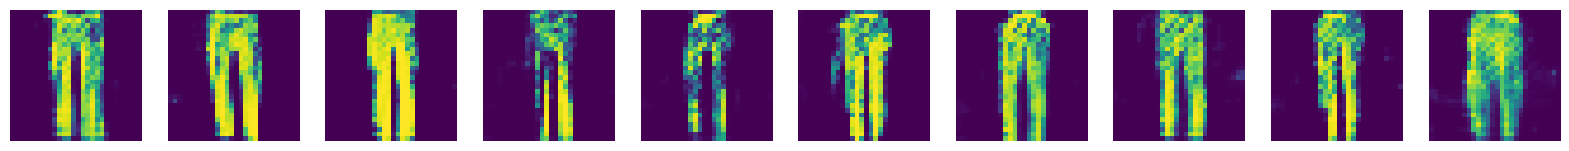


Saved to ./output/generated_img_005_label_2.png


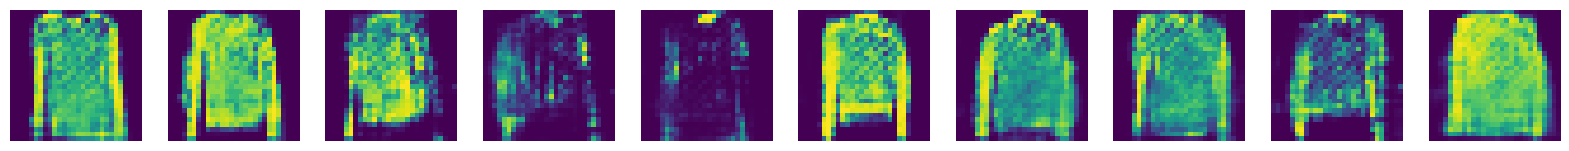

469/469 [==============================] - 198s 423ms/step - c_loss: -1.8727 - c_wass_loss: -2.0893 - c_gp: 0.0217 - g_loss: -15.2013
Epoch 7/50
469/469 [==============================] - ETA: 0s - c_loss: -1.7005 - c_wass_loss: -1.8959 - c_gp: 0.0195 - g_loss: -17.6927
Saved to ./output/generated_img_006_label_0.png


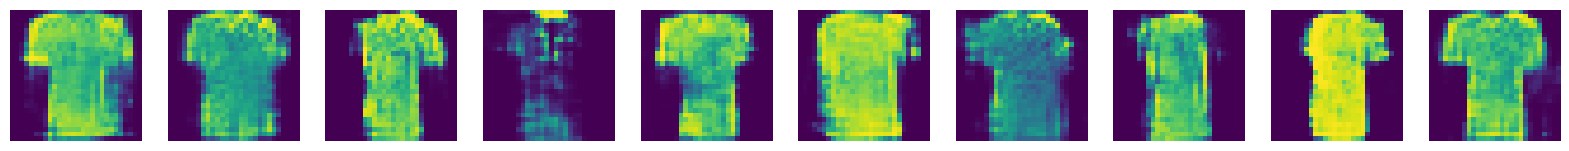


Saved to ./output/generated_img_006_label_1.png


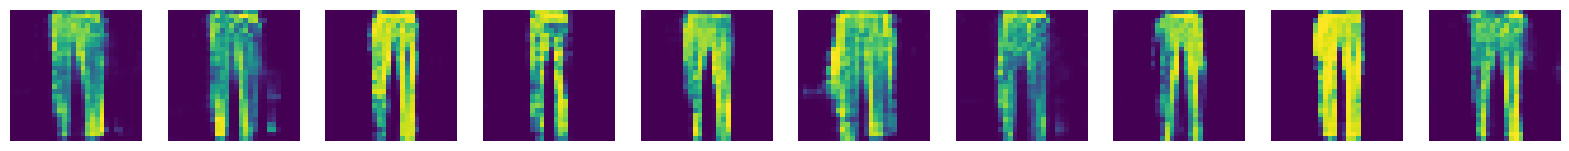


Saved to ./output/generated_img_006_label_2.png


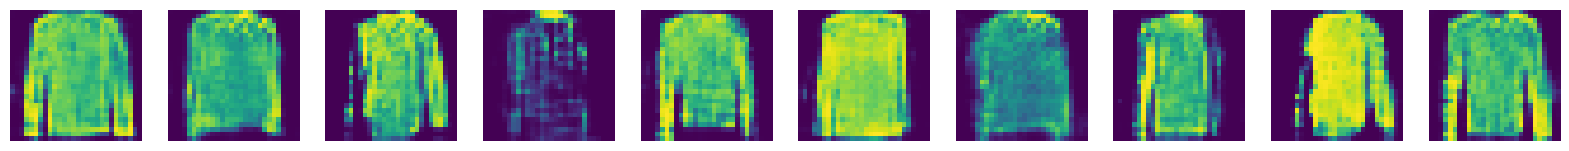

469/469 [==============================] - 198s 422ms/step - c_loss: -1.7005 - c_wass_loss: -1.8959 - c_gp: 0.0195 - g_loss: -17.6927
Epoch 8/50
469/469 [==============================] - ETA: 0s - c_loss: -1.5279 - c_wass_loss: -1.7011 - c_gp: 0.0173 - g_loss: -17.7473
Saved to ./output/generated_img_007_label_0.png


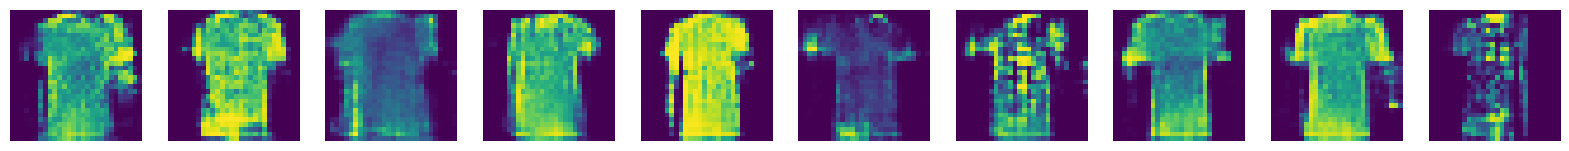


Saved to ./output/generated_img_007_label_1.png


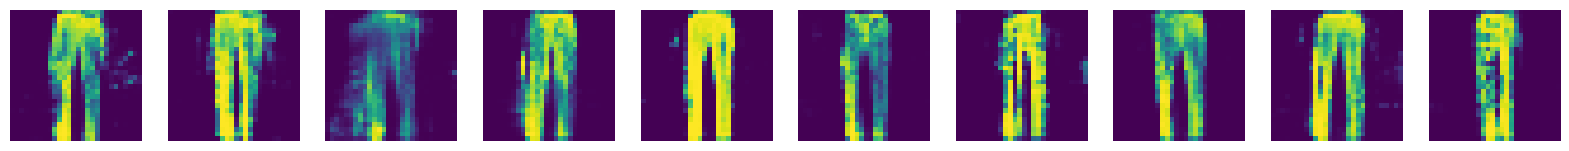


Saved to ./output/generated_img_007_label_2.png


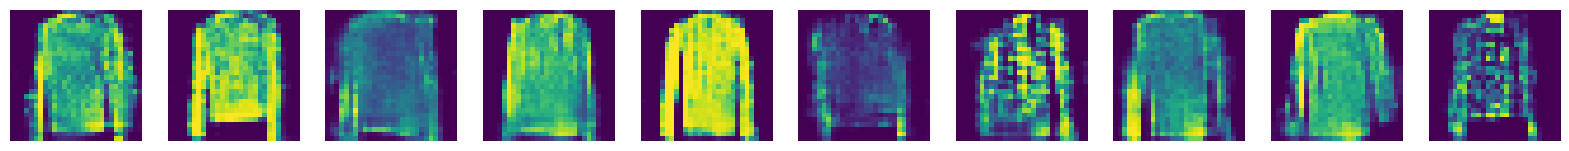

469/469 [==============================] - 199s 424ms/step - c_loss: -1.5279 - c_wass_loss: -1.7011 - c_gp: 0.0173 - g_loss: -17.7473
Epoch 9/50
469/469 [==============================] - ETA: 0s - c_loss: -1.4328 - c_wass_loss: -1.6019 - c_gp: 0.0169 - g_loss: -17.2587
Saved to ./output/generated_img_008_label_0.png


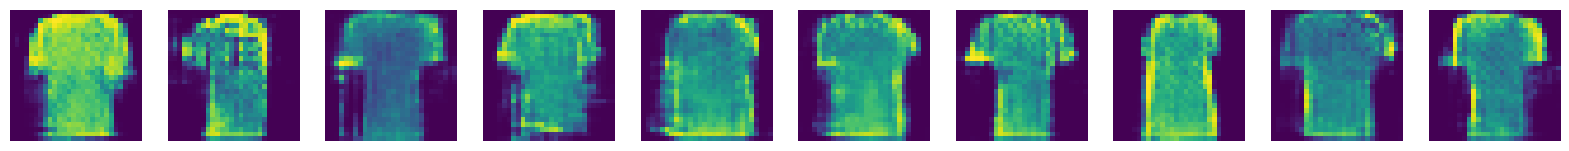


Saved to ./output/generated_img_008_label_1.png


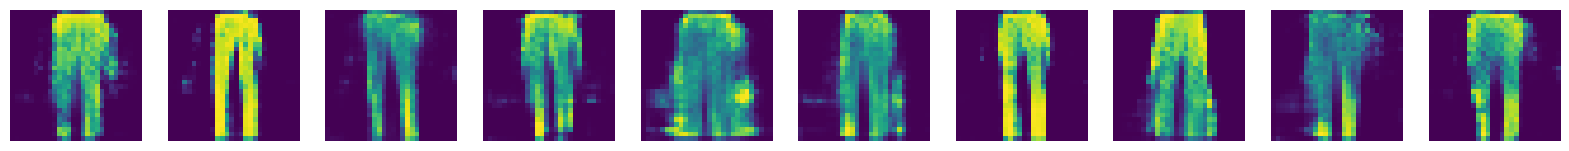


Saved to ./output/generated_img_008_label_2.png


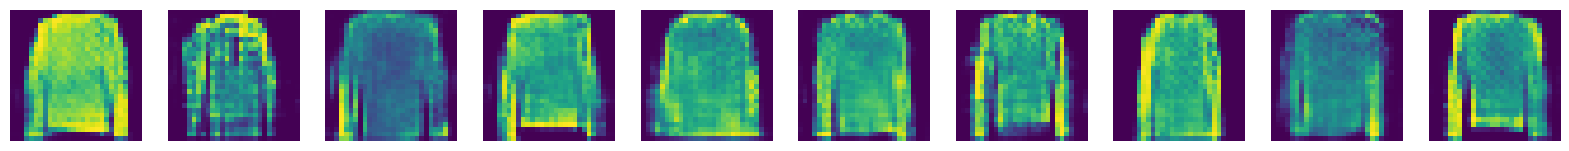

469/469 [==============================] - 198s 423ms/step - c_loss: -1.4328 - c_wass_loss: -1.6019 - c_gp: 0.0169 - g_loss: -17.2587
Epoch 10/50
469/469 [==============================] - ETA: 0s - c_loss: -1.3257 - c_wass_loss: -1.4799 - c_gp: 0.0154 - g_loss: -17.0945
Saved to ./output/generated_img_009_label_0.png


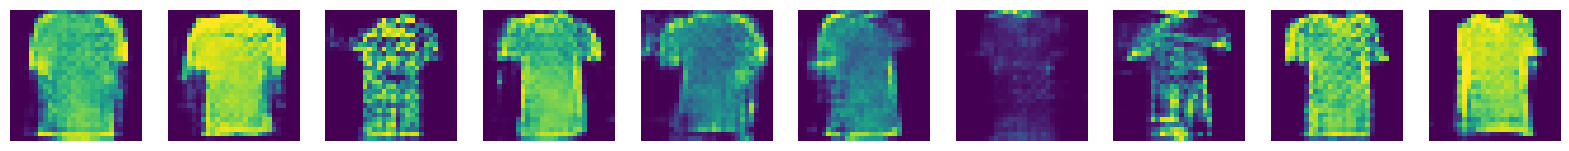


Saved to ./output/generated_img_009_label_1.png


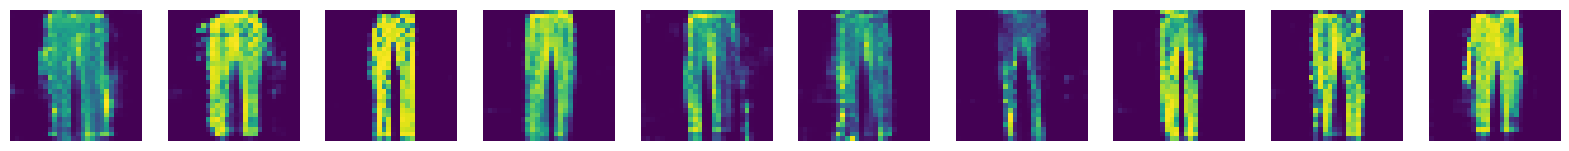


Saved to ./output/generated_img_009_label_2.png


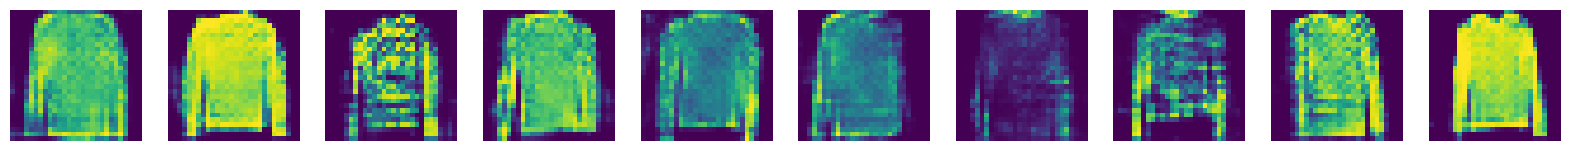

469/469 [==============================] - 200s 425ms/step - c_loss: -1.3257 - c_wass_loss: -1.4799 - c_gp: 0.0154 - g_loss: -17.0945
Epoch 11/50
469/469 [==============================] - ETA: 0s - c_loss: -1.2681 - c_wass_loss: -1.4141 - c_gp: 0.0146 - g_loss: -18.4313
Saved to ./output/generated_img_010_label_0.png


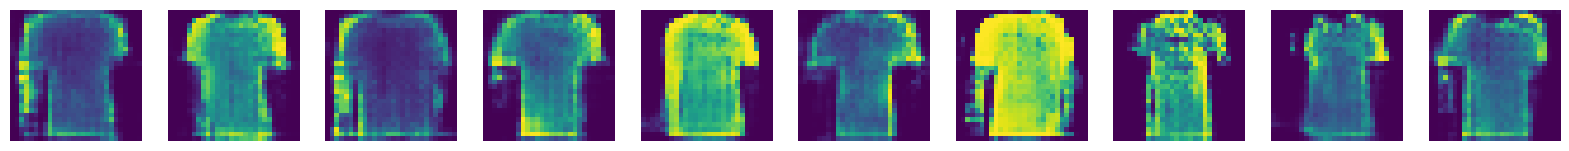


Saved to ./output/generated_img_010_label_1.png


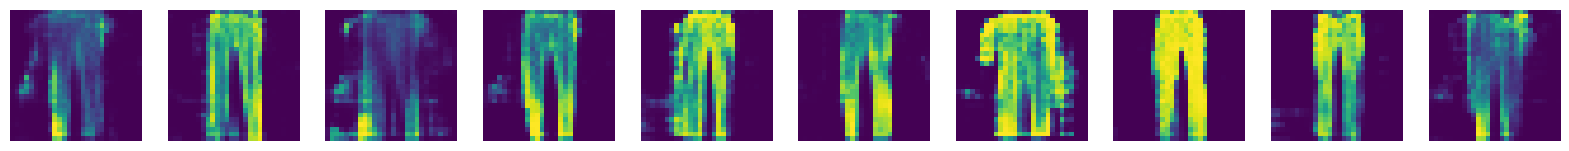


Saved to ./output/generated_img_010_label_2.png


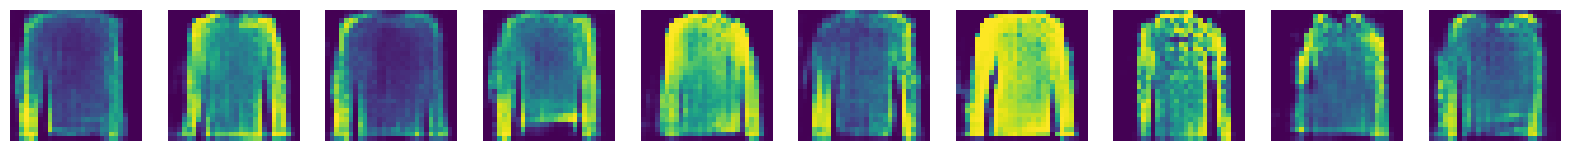

469/469 [==============================] - 199s 424ms/step - c_loss: -1.2681 - c_wass_loss: -1.4141 - c_gp: 0.0146 - g_loss: -18.4313
Epoch 12/50
303/469 [==================>...........] - ETA: 1:09 - c_loss: -1.2014 - c_wass_loss: -1.3395 - c_gp: 0.0138 - g_loss: -20.1636

KeyboardInterrupt: 

In [27]:
history = cgan.fit(
    x_train,
    y_train,
    epochs=50,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator(num_img=10, latent_dim=100),
    ],
    batch_size= 128
)

## Generating output respresinting different label

In [28]:
z_sample = np.random.normal(size=(10, 100))

### Label 0: Tshit/ Top

1/1 [==============================] - 0s 60ms/step


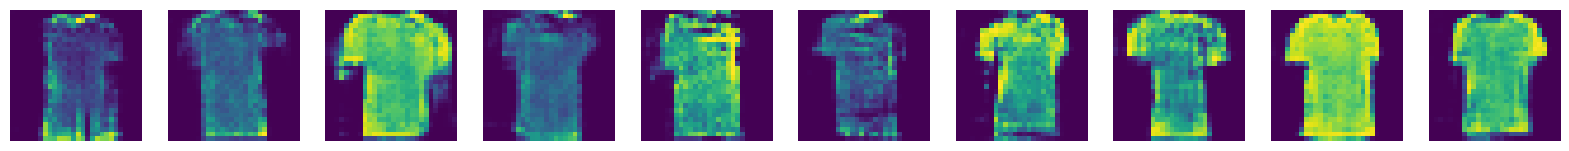

In [41]:
class_label = np.repeat([[1, 0,0,0,0,0,0,0,0,0]], 10, axis=0)
imgs = cgan.generator.predict([z_sample, class_label])
display(imgs, cmap=None)

### Label 1: Trouser

1/1 [==============================] - 0s 20ms/step


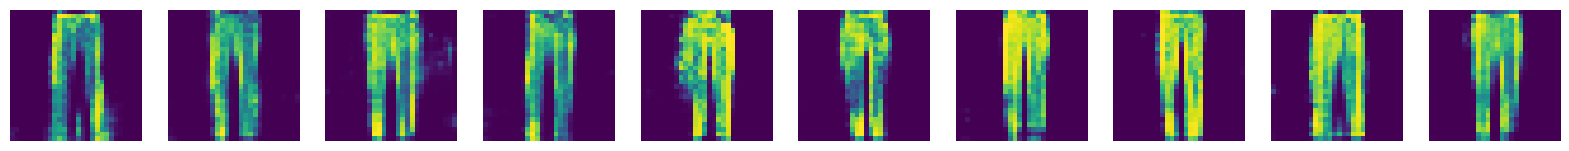

In [30]:
class_label = np.repeat([[0, 1,0,0,0,0,0,0,0,0]], 10, axis=0)
imgs = cgan.generator.predict([z_sample, class_label])
display(imgs, cmap=None)

### Label 2: Pullover

1/1 [==============================] - 0s 27ms/step


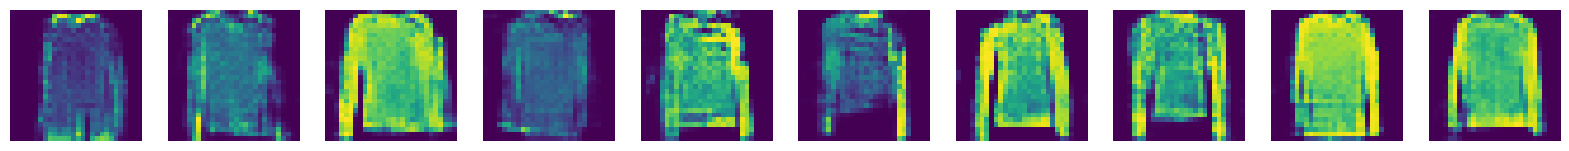

In [31]:
class_label = np.repeat([[0, 0,1,0,0,0,0,0,0,0]], 10, axis=0)
imgs = cgan.generator.predict([z_sample, class_label])
display(imgs, cmap=None)

### Label 3: Dress/ gown

1/1 [==============================] - 0s 33ms/step


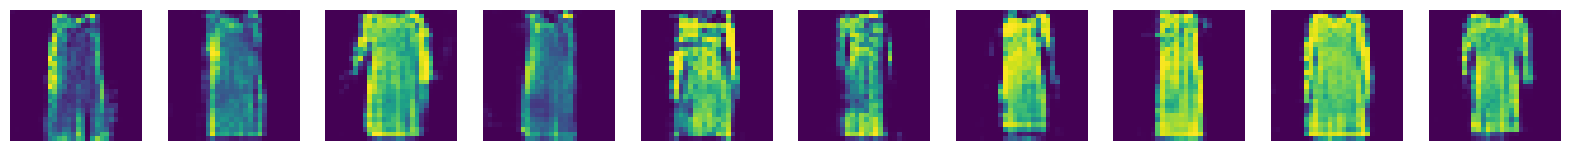

In [32]:
class_label = np.repeat([[0, 0,0,1,0,0,0,0,0,0]], 10, axis=0)
imgs = cgan.generator.predict([z_sample, class_label])
display(imgs, cmap=None)

### Label 4: Coat

1/1 [==============================] - 0s 33ms/step


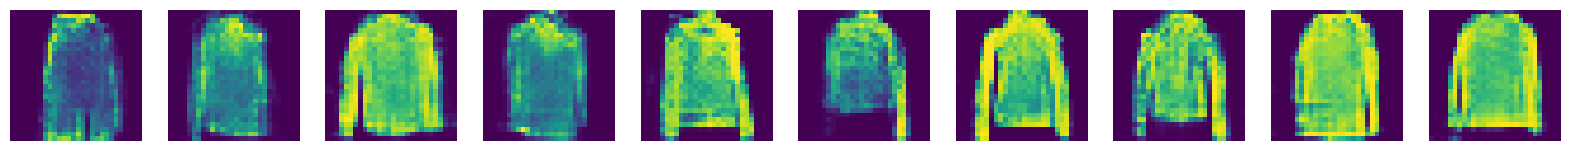

In [33]:
class_label = np.repeat([[0, 0,0,0,1,0,0,0,0,0]], 10, axis=0)
imgs = cgan.generator.predict([z_sample, class_label])
display(imgs, cmap=None)

### Label 5: Sandal

1/1 [==============================] - 0s 30ms/step


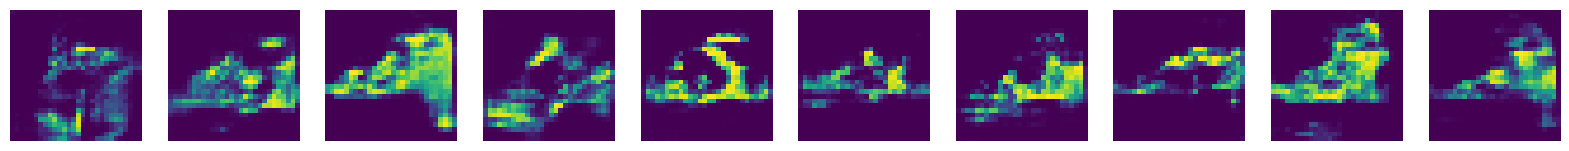

In [34]:
class_label = np.repeat([[0, 0,0,0,0,1,0,0,0,0]], 10, axis=0)
imgs = cgan.generator.predict([z_sample, class_label])
display(imgs, cmap=None)

### Label 6: Shirt

1/1 [==============================] - 0s 20ms/step


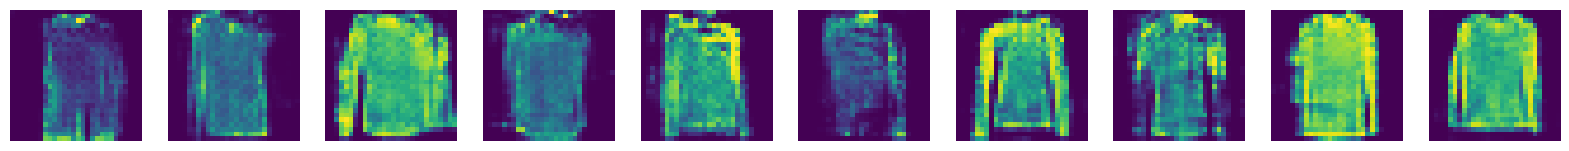

In [35]:
class_label = np.repeat([[0, 0,0,0,0,0,1,0,0,0]], 10, axis=0)
imgs = cgan.generator.predict([z_sample, class_label])
display(imgs, cmap=None)

### Label 7: Sneakers

1/1 [==============================] - 0s 22ms/step


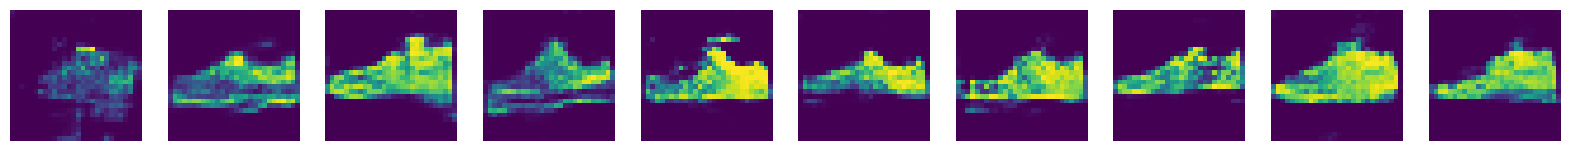

In [36]:
class_label = np.repeat([[0, 0,0,0,0,0,0,1,0,0]], 10, axis=0)
imgs = cgan.generator.predict([z_sample, class_label])
display(imgs, cmap=None)

### Label 8: Bag

1/1 [==============================] - 0s 21ms/step


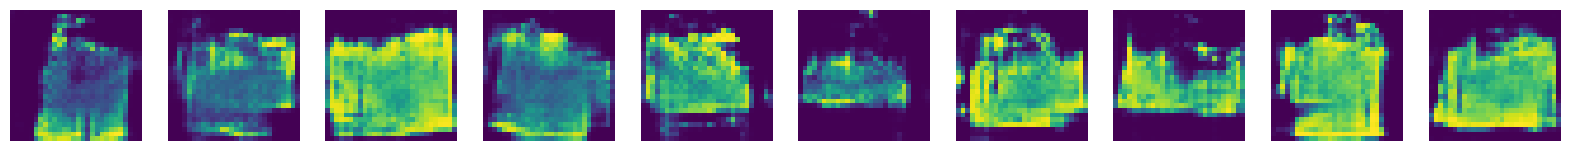

In [37]:
class_label = np.repeat([[0, 0,0,0,0,0,0,0,1,0]], 10, axis=0)
imgs = cgan.generator.predict([z_sample, class_label])
display(imgs, cmap=None)

### Label 9: Ankle Boot

1/1 [==============================] - 0s 45ms/step


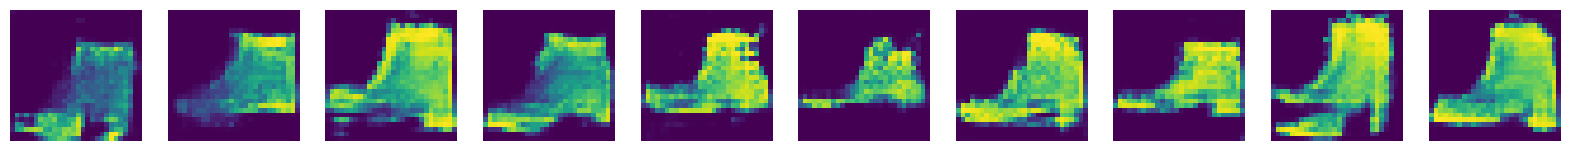

In [38]:
class_label = np.repeat([[0, 0,0,0,0,0,0,0,0,1]], 10, axis=0)
imgs = cgan.generator.predict([z_sample, class_label])
display(imgs, cmap=None)